In [1]:
# For kaggle uncomment this all


# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/techparva3-datathon/sample_submission.csv
/kaggle/input/techparva3-datathon/train.csv
/kaggle/input/techparva3-datathon/test.csv


# 1. Import Necessary Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# 2. Loading Training and Testing Data

In [17]:
#For kaggle
# train_df = pd.read_csv('/kaggle/input/techparva3-datathon/train.csv')
# test_df = pd.read_csv('/kaggle/input/techparva3-datathon/test.csv')
# For jupyter notebook
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 3. Data Cleaning and Encoding
#### This function preprocesses the input DataFrame by handling missing values, removing unnecessary columns, managing outliers, encoding categorical variables, and engineering new features. It ensures the dataset is clean and ready for machine learning models.

In [18]:
def clean_and_encode_data(df):
    """
    Cleans and encodes a DataFrame for use in training or testing.

    Parameters:
    df (pd.DataFrame): The input DataFrame to process.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    # Drop unwanted columns
    columns_to_drop = ['issue_date_year', 'issue_date_hour', 
                       'application_type', 'emp_title', 'member_id',
                       'last_credit_pull_date', 'last_payment_date', 'next_payment_date', 'issue_date']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Handle missing values with median imputation
    median_impute_columns = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
    for col in median_impute_columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Remove duplicates
    df = df.drop_duplicates()

    # Handle outliers using the IQR method
    numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
    for col in numerical_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Convert 'emp_length' to numeric
    def convert_emp_length(emp_length):
        if isinstance(emp_length, str):
            if '< 1 year' in emp_length:
                return 0.0
            elif '10+ years' in emp_length:
                return 10.0
            else:
                try:
                    return float(emp_length.split(' ')[0])
                except ValueError:
                    return None
        return None

    if 'emp_length' in df.columns:
        df['emp_length_num'] = df['emp_length'].apply(convert_emp_length)
        df = df.drop(columns=['emp_length'], errors='ignore')

    # Label encode ordinal columns (if applicable)
    if 'grade' in df.columns:
        le = LabelEncoder()
        df['grade'] = le.fit_transform(df['grade'])

    # One-hot encode categorical columns
    categorical_cols = ['home_ownership', 'loan_status', 'term', 'verification_status', 'purpose', 'address_state']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Feature engineering: Loan-to-Income ratio
    if 'loan_amount' in df.columns and 'annual_income' in df.columns:
        df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']

    # Feature engineering: Interest-to-Loan ratio
    if 'int_rate' in df.columns and 'loan_amount' in df.columns:
        df['interest_to_loan_ratio'] = df['int_rate'] / df['loan_amount']

    # Move grade column to the last column if grade exist
    if 'grade' in df.columns:
        grade_col = df.pop('grade')
        df['grade'] = grade_col

    return df

In [19]:
# Clean and encode the training dataset
df = clean_and_encode_data(train_df)

# Display the first few rows of the processed dataset
print(df.head())

# Display the shape of the processed dataset
print("Processed Data Shape:", df.shape)

   annual_income       dti  installment  int_rate   loan_amount  total_acc  \
0   82438.124601  0.072151    62.006774  0.161206   9586.945180   1.953600   
1   52347.892639  0.140367   373.547998  0.117188   2213.200815  22.458280   
2  -38314.485684  0.125850   529.631006  0.089163  15608.890161  22.484164   
4   75400.804843  0.136576   510.555677  0.091857   4109.600739  22.484164   
5   37644.181964  0.136576    25.038060  0.154825  10452.853309  -0.389276   

   total_payment  issue_date_month  issue_date_day  issue_date_weekday  ...  \
0   14241.661213                 8               7                   5  ...   
1   12901.399781                 4               9                   4  ...   
2   10082.118704                 7              10                   5  ...   
4   13485.994361                 1              10                   6  ...   
5    1544.880114                11              10                   2  ...   

   address_state_UT  address_state_VA  address_state_VT 

# 4. Exploratory Data Analysis

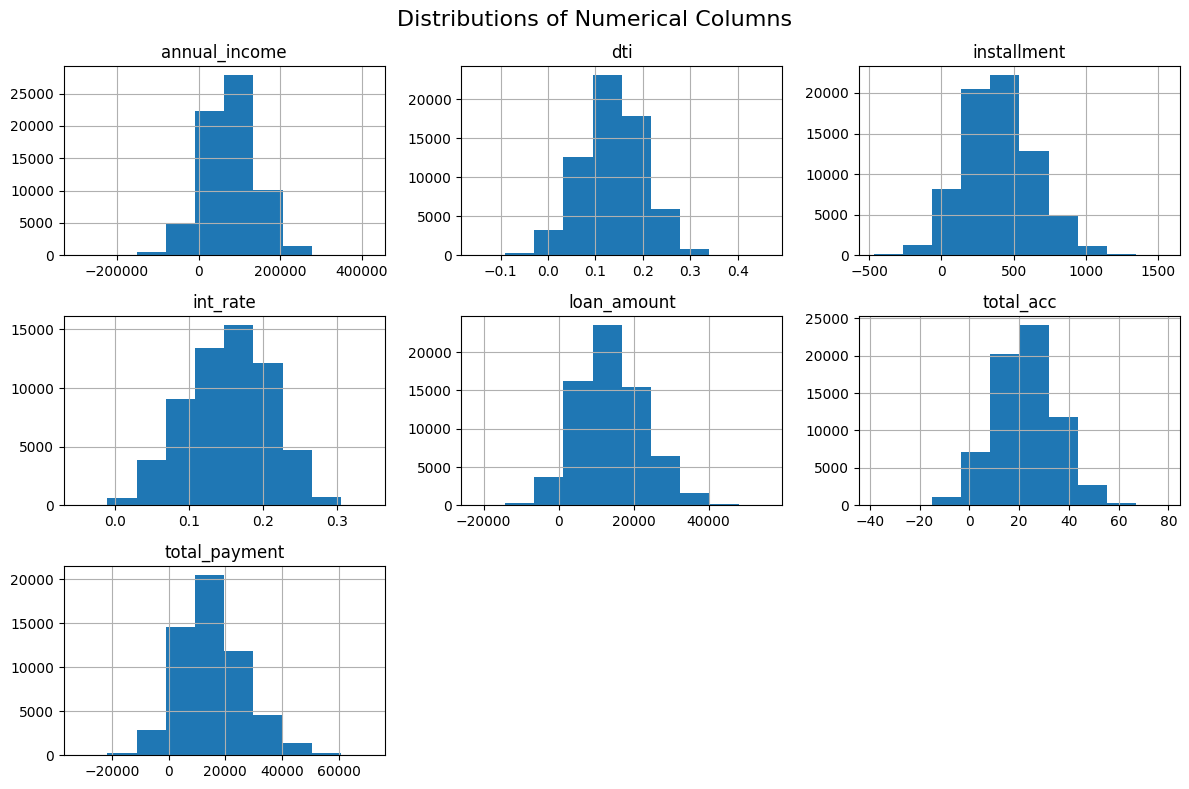

In [20]:
# 1. Visualize distributions of numerical columns
train_df[['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']].hist(figsize=(12, 8))
plt.suptitle('Distributions of Numerical Columns', fontsize=16)
plt.tight_layout()
plt.show()

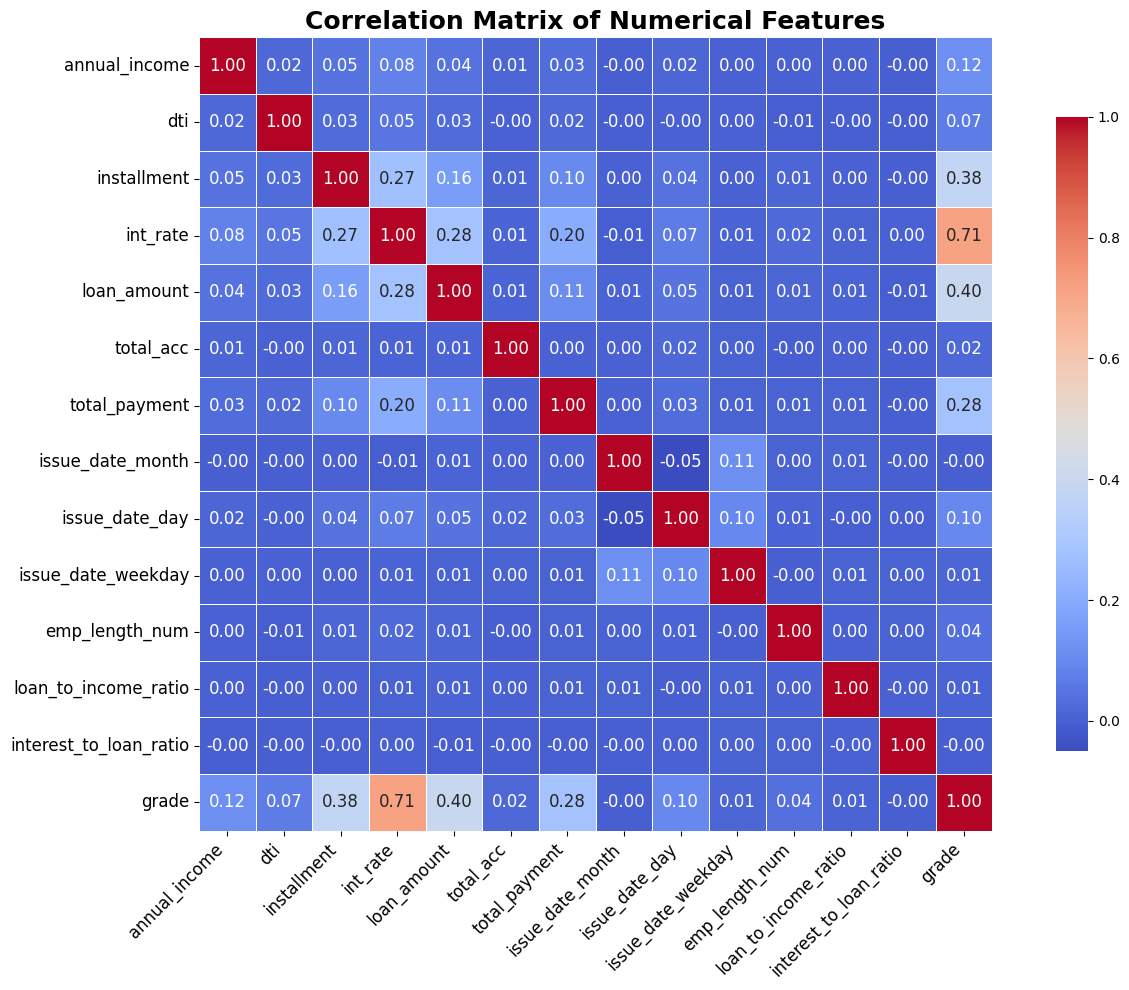

In [21]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Set the figure size
plt.figure(figsize=(14, 10))

# Create the heatmap
sns.heatmap(
    numeric_df.corr(),                # Correlation matrix
    annot=True,                        # Display correlation values
    cmap='coolwarm',                   # Color palette
    fmt='.2f',                         # Format the annotations
    linewidths=0.5,                    # Line thickness between cells
    annot_kws={"size": 12},            # Font size of annotations
    cbar_kws={'shrink': 0.8},          # Shrink color bar
    square=True,                       # Make the heatmap square-shaped
    xticklabels=numeric_df.columns,    # Set x-axis labels
    yticklabels=numeric_df.columns,    # Set y-axis labels
)

# Add title with custom font size
plt.title('Correlation Matrix of Numerical Features', fontsize=18, fontweight='bold')

# Rotate the x and y labels to make them more readable
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

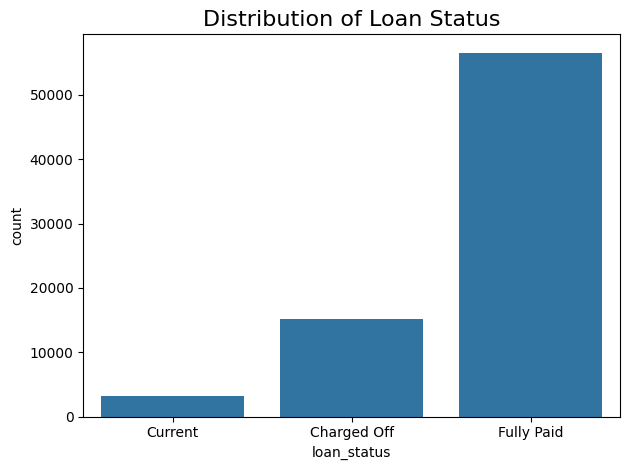

In [22]:
# 3. Visualize the relationship between 'loan_status' and other features
sns.countplot(x='loan_status', data=train_df)
plt.title('Distribution of Loan Status', fontsize=16)
plt.tight_layout()
plt.show()

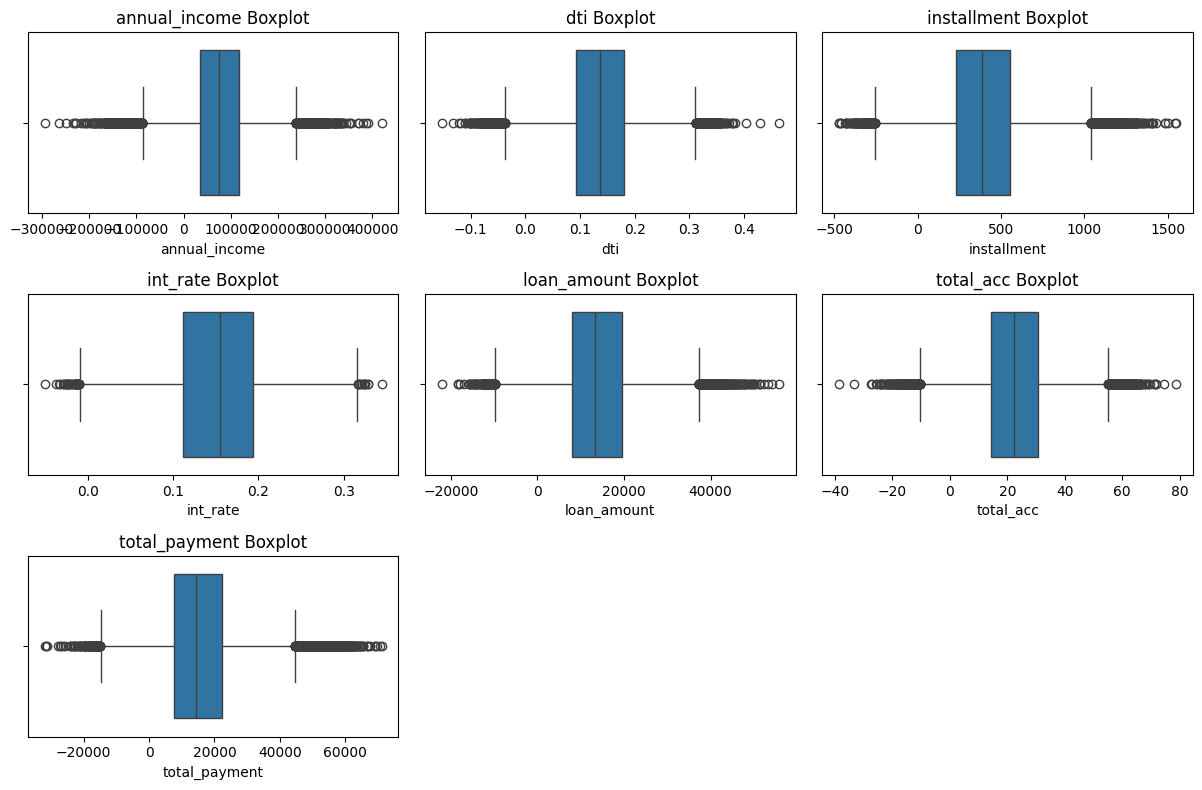

In [23]:
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

In [25]:
for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]


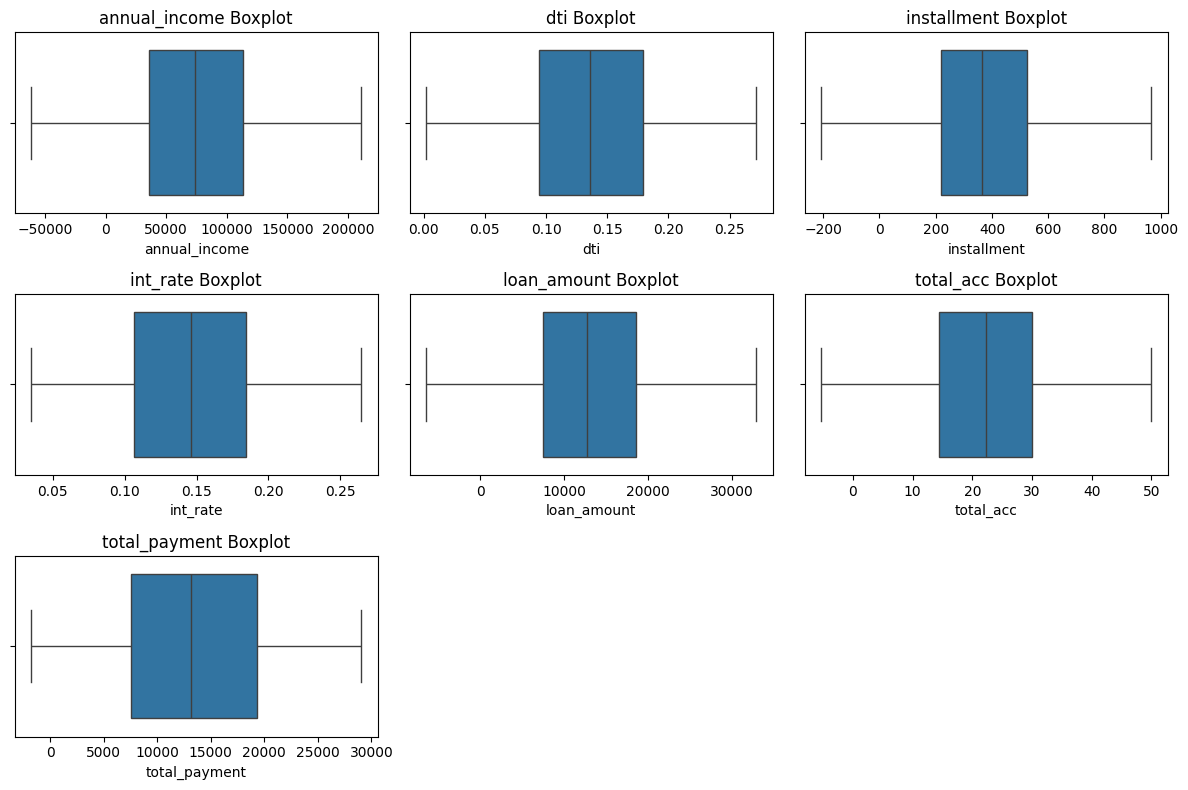

In [26]:
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

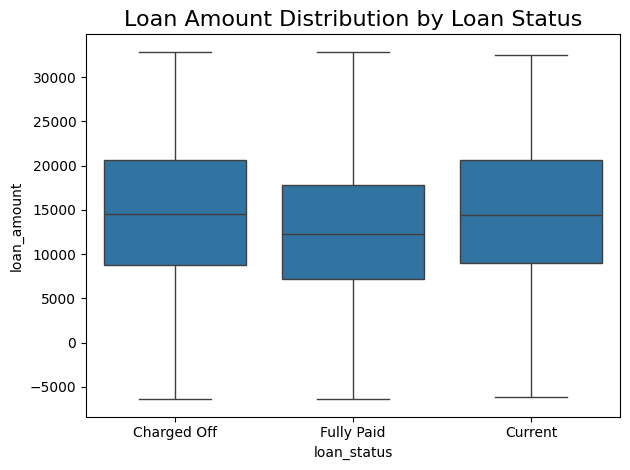

In [28]:
# 4. Boxplot to check for outliers between loan_status and loan_amount
sns.boxplot(x='loan_status', y='loan_amount', data=train_df)
plt.title('Loan Amount Distribution by Loan Status', fontsize=16)
plt.tight_layout()
plt.show()

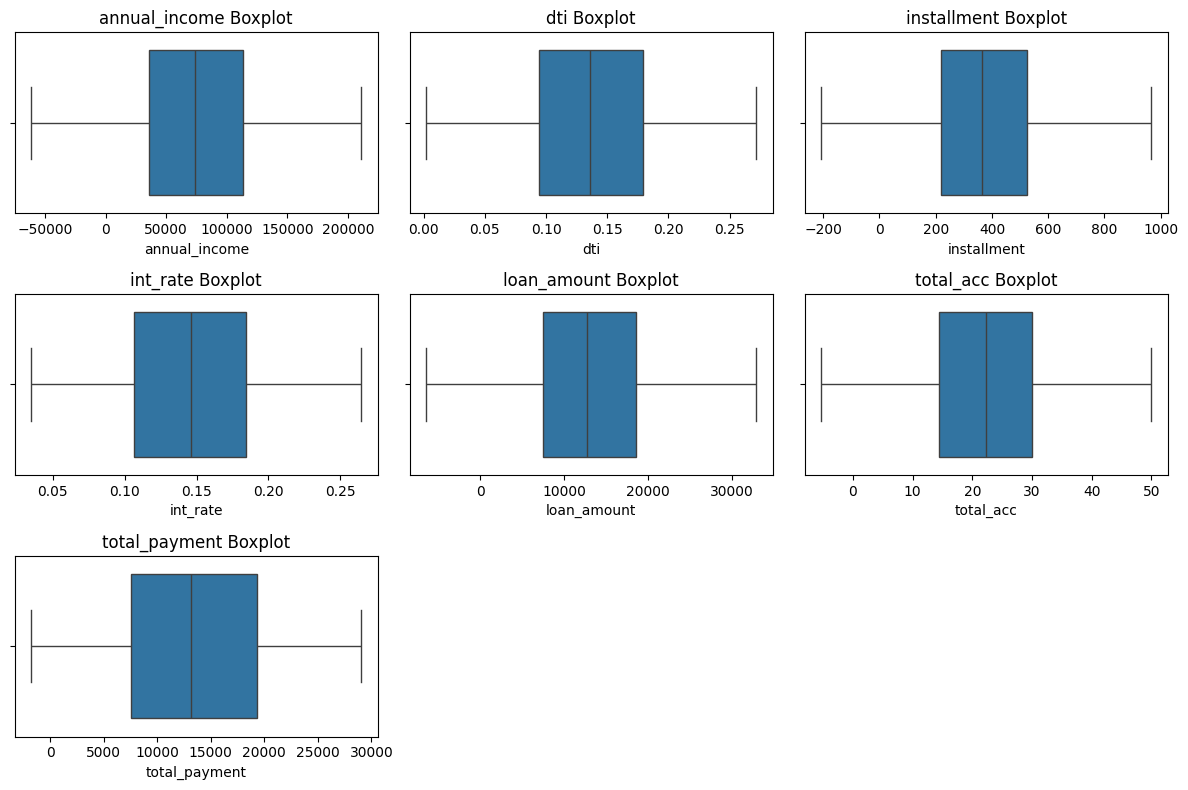

In [30]:
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()


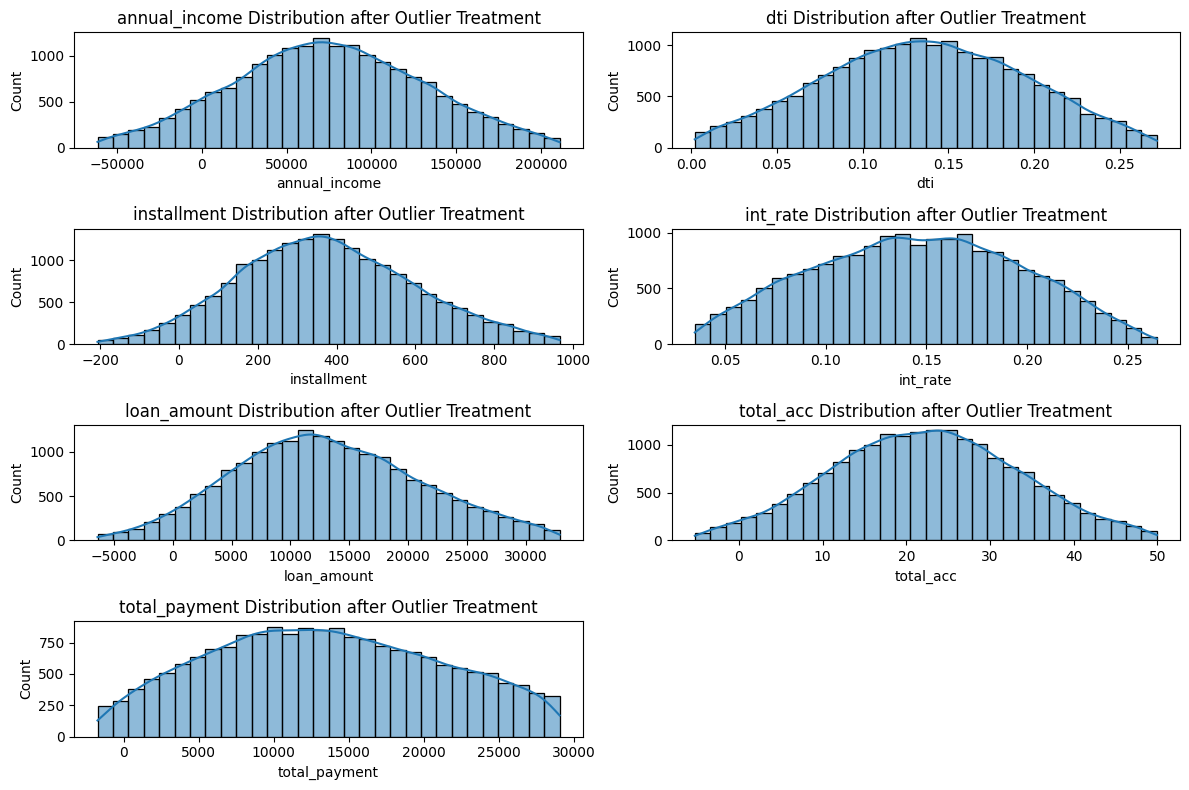

In [31]:
import warnings

# Filter out the specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'{col} Distribution after Outlier Treatment')
plt.tight_layout()
plt.show()


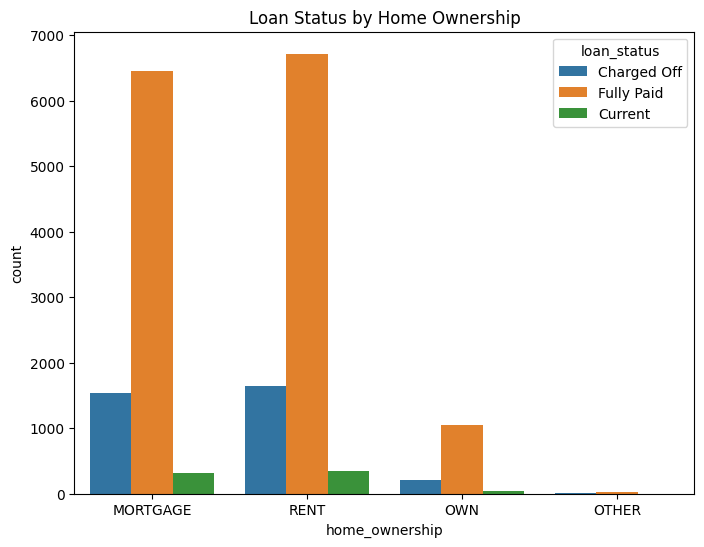

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', hue='loan_status', data=train_df)
plt.title('Loan Status by Home Ownership')
plt.show()

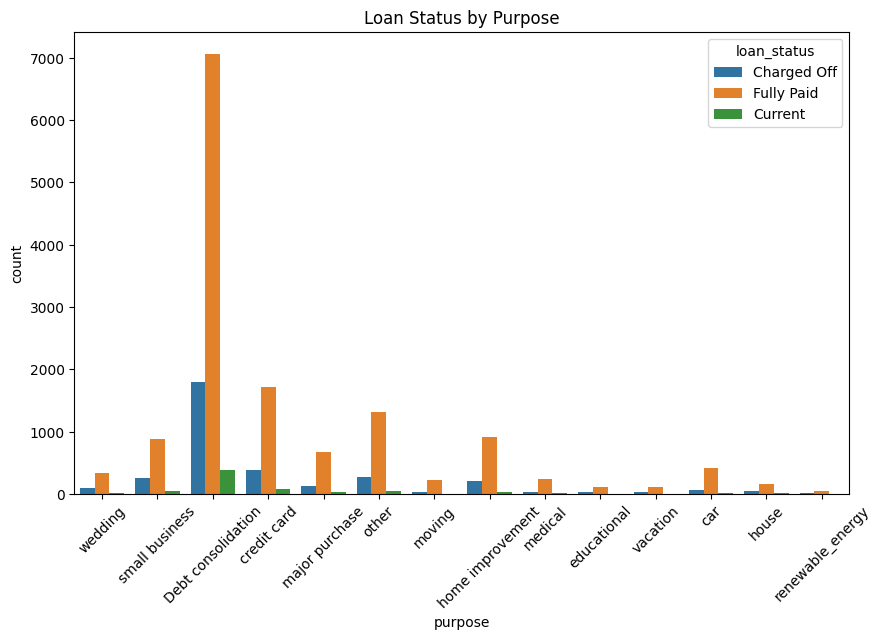

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x='purpose', hue='loan_status', data=train_df)
plt.xticks(rotation=45)
plt.title('Loan Status by Purpose')
plt.show()

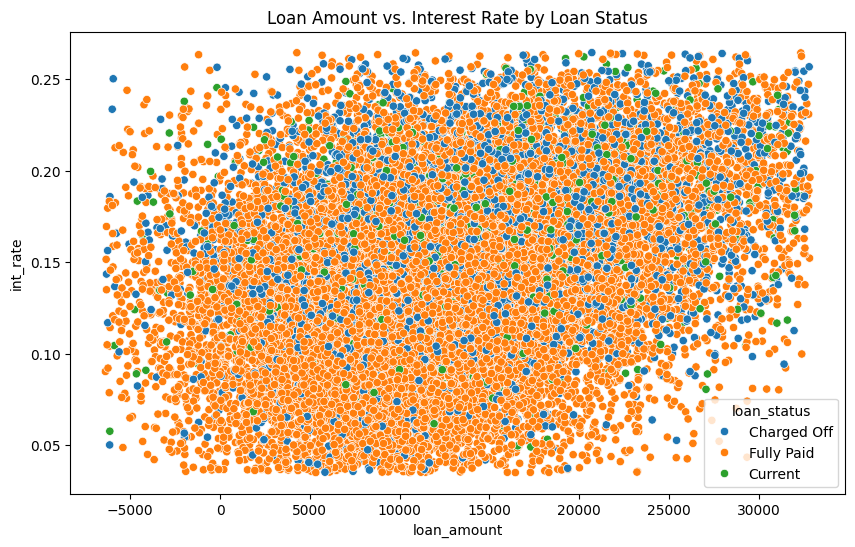

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loan_amount', y='int_rate', hue='loan_status', data=train_df)
plt.title('Loan Amount vs. Interest Rate by Loan Status')
plt.show()


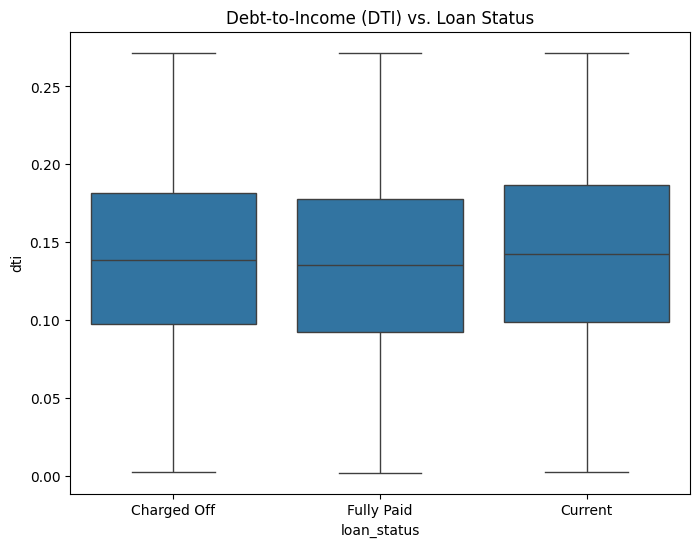

In [35]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_status', y='dti', data=train_df)
plt.title('Debt-to-Income (DTI) vs. Loan Status')
plt.show()


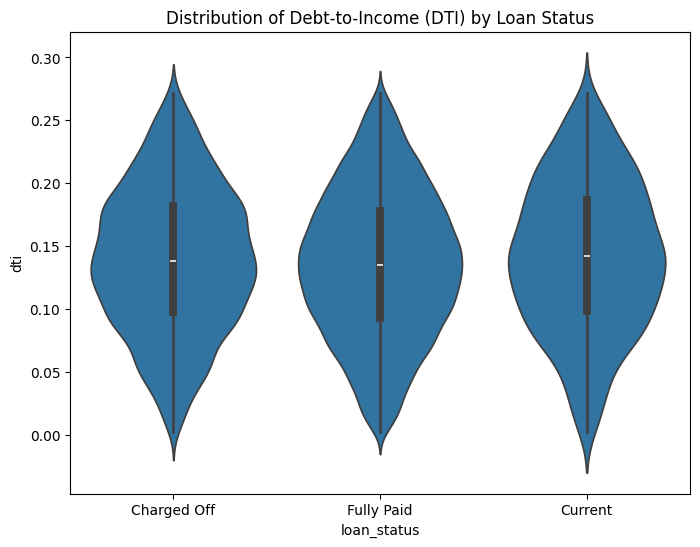

In [41]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='loan_status', y='dti', data=train_df)
plt.title('Distribution of Debt-to-Income (DTI) by Loan Status')
plt.show()


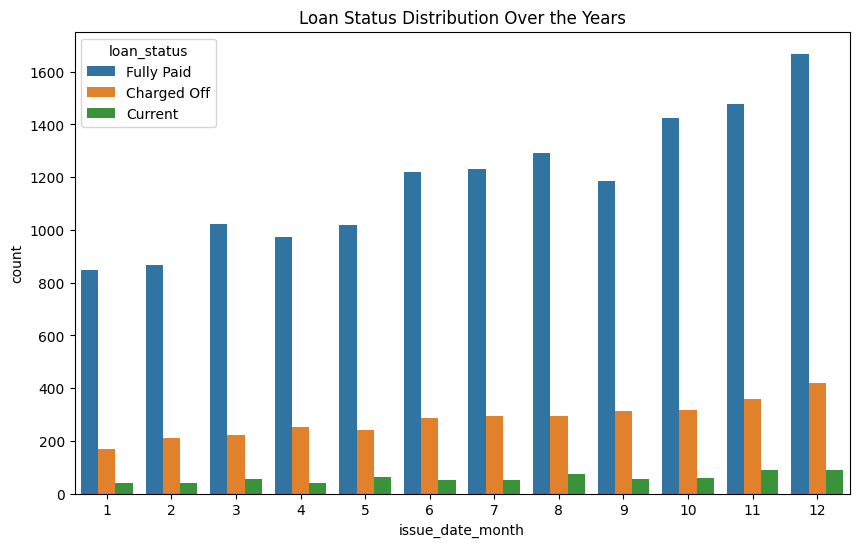

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='issue_date_month', hue='loan_status', data=train_df)
plt.title('Loan Status Distribution Over the Years')
plt.show()


# 5. Building Model


### 5.1. Preparing the data

In [62]:
X = df.drop('grade', axis=1)  
y = df['grade']

### 5.2. Split the Data into Train and Test Sets

In [66]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.3. Apply StandardScaler to the Training and Testing Features

In [68]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the numerical columns for scaling
numerical_columns = ['annual_income', 'dti', 'loan_amount', 'installment', 'int_rate', 'total_acc', 
                     'total_payment', 'loan_to_income_ratio', 'interest_to_loan_ratio']

# Apply scaling on the training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Apply the same scaling on the test data (using the statistics from the training data)
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Check the scaled values
print(X_train[numerical_columns].head())


       annual_income       dti  loan_amount  installment  int_rate  total_acc  \
36815       1.482729  0.812642     2.256092    -1.735224  0.484194   0.486540   
67992       0.282820  1.770540     0.261342    -0.331412  0.092319   0.448150   
27545      -1.040937 -0.748613    -0.042776    -0.359165 -2.052160   0.805899   
10656      -2.461577  1.210468     0.602220     0.098670 -0.279883   0.129222   
63208       0.288935 -0.884747    -0.575257    -1.047934  0.092319   1.669844   

       total_payment  loan_to_income_ratio  interest_to_loan_ratio  
36815       0.725875              0.002234               -0.005874  
67992       0.020327              0.000923               -0.004745  
27545       0.020327              0.025246               -0.006256  
10656      -1.473853             -0.022059               -0.005366  
63208       0.020327             -0.002460               -0.002908  


### 5.4 Training Model using XGBOOST

In [ ]:
# Optional: Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Define the XGBoost model with early stopping
xgboost_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=7,  # Number of classes in 'loan_grade'
    eval_metric='mlogloss',  # Metric for multi-class classification
    early_stopping_rounds=10
)

# Setting up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [72]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.43655737704918035
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1860
           1       0.38      0.40      0.39      1935
           2       0.38      0.28      0.33      1804
           3       0.37      0.39      0.38      1943
           4       0.33      0.34      0.34      1695
           5       0.41      0.40      0.40      1578
           6       0.53      0.50      0.52      1385

    accuracy                           0.44     12200
   macro avg       0.43      0.44      0.43     12200
weighted avg       0.43      0.44      0.43     12200

